# Data Preparation

In [1]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('train.csv', sep=';')
features.head(5)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
0,-0.458258,-0.579012,2.886009,-0.075516,1.674060,-2.431912,0.534850,-0.846473,2
1,1.626615,-0.028332,-1.443184,-1.007447,-0.989093,1.202627,-0.038211,-1.298616,0
2,1.721356,-0.137676,-1.322593,-1.333187,-0.723713,0.843285,-0.588495,0.066682,0
3,-0.715103,3.265915,-0.791030,-2.967881,2.497628,-0.277387,-0.551611,0.668354,2
4,2.944098,0.197871,-2.257025,1.032789,-4.104693,4.716115,-0.380813,-1.393825,0


In [2]:
print('The shape of our features is:', features.shape)

The shape of our features is: (2100, 9)


## Features and Labels

In [6]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['target'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('target', axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

## Training and Testing Sets

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=42)

In [10]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1575, 8)
Training Labels Shape: (1575,)
Testing Features Shape: (525, 8)
Testing Labels Shape: (525,)


## Instantiating and training the Forest

In [48]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rf = RandomForestRegressor()

### Tuning hyperparameters

Creating a parameter grid

In [50]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Using the random grid to search for best hyperparameters

In [51]:
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [52]:
# Print out the best hyperparameters
print(rf_random.best_params_)

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

Applying the best hyperparameters

In [70]:
rf = rf_random.best_estimator_

## Make Predictions on Test Data

In [71]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate and display accuracy
accuracy = rf.score(test_features, test_labels)
print('Accuracy:', accuracy * 100, '%.')

Mean Absolute Error: 0.19
Accuracy: 79.50400004476569 %.


## Variable Importances

In [72]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: feature6             Importance: 0.3
Variable: feature3             Importance: 0.2
Variable: feature5             Importance: 0.15
Variable: feature1             Importance: 0.12
Variable: feature2             Importance: 0.12
Variable: feature4             Importance: 0.07
Variable: feature7             Importance: 0.02
Variable: feature8             Importance: 0.02


## Visualizations

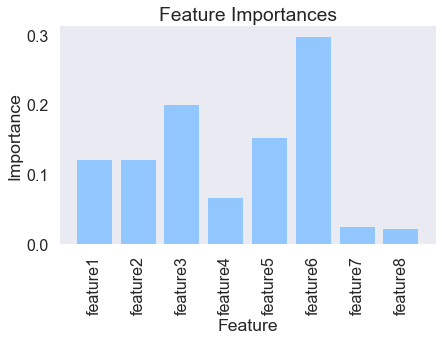

In [73]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('seaborn-pastel')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances'); 